# Running TensorTrade on SageMaker Studio
This notebook demonstrates running TensorTrade on SageMaker Studio. EOD data for any ETF/stock is fetched from [Yahoo Finance](https://finance.yahoo.com/) or S3 bucket. Experimental evidence shows that running on ml.g4dn.xlarge instance completes sooner than running on ml.t3.medium instance.

In [1]:
!pip install pip --upgrade
!pip install git+https://github.com/msrparadesi/tensortrade.git
!pip install git+https://github.com/msrparadesi/tensortrade.git#egg=tensortrade[tf,tensorforce,baselines,ccxt,ta,fbm] -U
!pip install yfinance ta matplotlib s3fs

  Using cached pip-20.1.1-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
  Cloning https://github.com/msrparadesi/tensortrade.git to /tmp/pip-req-build-i8sut2x8
  Running command git clone -q https://github.com/msrparadesi/tensortrade.git /tmp/pip-req-build-i8sut2x8
  Using cached pandas-1.0.5-cp36-cp36m-manylinux1_x86_64.whl (10.1 MB)
Processing ./.cache/pip/wheels/be/a1/84/6b4caa6c1cea703acbfea8a24cc3c1729bd359cd4a65755d8b/gym-0.17.2-py3-none-any.whl
  Using cached sympy-1.6.1-py3-none-any.whl (5.8 MB)
  Using cached pyglet-1.5.0-py2.py3-none-any.whl (1.0 MB)
Processing ./.cache/pip/wheels/e8/38/69/aa17553ad31f09ff5fa44c8a1a6c5b47e7c9261e9c7c16b9fb/mpmath-1.1.0-py3-none-any.whl
Processing ./.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94/future-0.18.2-py3-none-any.whl
  Created wheel for tensortrade: filename=tensortrade-0.2.0b2-p

### Declare variables that are used in this analysis

In [2]:
symbol = 'SPY'
exchange = 'NASDAQ'
start_date = '2010-01-01'
end_date = '2020-06-30'

### Fetch EOD data of ETF/stock
Option 1: Fetch data from Yahoo Finance

In [3]:
import yfinance as yf
data = yf.download(symbol, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,91.841896,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.084984,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.149803,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.538841,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,92.846756,126402800


(Optional) Save the ETF/stock EOD data in S3

In [4]:
import sagemaker
bucket = sagemaker.Session().default_bucket()
prefix = 'data/'
data.reset_index(inplace=True)
data.to_csv('s3://'+ bucket + '/' + prefix + symbol + '.csv', index=False)

Option 2: Fetch data from S3 bucket

In [5]:
#import io
import pandas as pd
import sagemaker
bucket = sagemaker.Session().default_bucket()
prefix = 'data/'
data = pd.read_csv('s3://' + bucket + '/' + prefix + symbol + '.csv')
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,91.841896,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.084984,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.149803,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.538841,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,92.846756,126402800


### Generate features based on [technical analysis](https://github.com/bukosabino/ta) of the ETF/stock

In [6]:
import ta
ta.add_all_ta_features(data, 'Open', 'High', 'Low', 'Close', 'Volume', fillna=True)
data.columns = [symbol + ":" + name.lower() for name in data.columns]
data.head()

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


,SPY:open,SPY:high,SPY:low,SPY:close,SPY:adj close,SPY:volume,SPY:volume_adi,SPY:volume_obv,SPY:volume_cmf,SPY:volume_fi,...,SPY:momentum_uo,SPY:momentum_stoch,SPY:momentum_stoch_signal,SPY:momentum_wr,SPY:momentum_ao,SPY:momentum_kama,SPY:momentum_roc,SPY:others_dr,SPY:others_dlr,SPY:others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,91.841896,118944600,1.113527e+08,118944600,0.936173,0.000000e+00,...,0.000000,96.808636,96.808636,-3.191364,0.0,113.330002,0.0,-43.637407,0.000000,0.000000
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.084984,111579900,2.094884e+08,230524500,0.908747,3.347346e+07,...,28.782253,97.695710,97.252173,-2.304290,0.0,113.471767,0.0,0.264710,0.264360,0.264710
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.149803,116074400,2.094884e+08,346598900,0.604412,3.001813e+07,...,32.415861,88.709707,94.404684,-11.290293,0.0,113.584301,0.0,0.070406,0.070381,0.335302
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.538841,131091100,3.086619e+08,477690000,0.646155,3.471899e+07,...,46.832592,95.035482,93.813633,-4.964518,0.0,113.859769,0.0,0.422129,0.421241,0.758846
2010-01-08,113.889999,114.620003,113.660004,114.570000,92.846756,126402800,4.218969e+08,604092800,0.698398,3.662095e+07,...,55.390283,98.392185,94.045791,-1.607815,0.0,114.186429,0.0,0.332776,0.332224,1.094148


### Create a 'DataFeed' for the Gym TradingEnvironment to be able to observe and make actions about
- Make a list of Stream objects, one for each DataFrame column

In [7]:
from tensortrade.data import Module, Stream

with Module(exchange) as node_stream:
    nodes = []
    for name in data.columns:
        nodes.append(Stream(list(data[name]), name))

In [8]:
from tensortrade.data import DataFeed
data_feed = DataFeed([node_stream])

In [9]:
data_feed.next() # Show 1 slice of the data

{'NASDAQ:/SPY:open': 112.37000274658205,
 'NASDAQ:/SPY:high': 113.38999938964844,
 'NASDAQ:/SPY:low': 111.51000213623048,
 'NASDAQ:/SPY:close': 113.33000183105469,
 'NASDAQ:/SPY:adj close': 91.8418960571289,
 'NASDAQ:/SPY:volume': 118944600,
 'NASDAQ:/SPY:volume_adi': 111352689.32573092,
 'NASDAQ:/SPY:volume_obv': 118944600,
 'NASDAQ:/SPY:volume_cmf': 0.9361727167583137,
 'NASDAQ:/SPY:volume_fi': 0.0,
 'NASDAQ:/SPY:momentum_mfi': 50.0,
 'NASDAQ:/SPY:volume_em': 0.0,
 'NASDAQ:/SPY:volume_sma_em': 0.0,
 'NASDAQ:/SPY:volume_vpt': -52024532.18648957,
 'NASDAQ:/SPY:volume_nvi': 1000.0,
 'NASDAQ:/SPY:volume_vwap': 112.7433344523112,
 'NASDAQ:/SPY:volatility_atr': 0.0,
 'NASDAQ:/SPY:volatility_bbm': 113.33000183105469,
 'NASDAQ:/SPY:volatility_bbh': 113.33000183105469,
 'NASDAQ:/SPY:volatility_bbl': 113.33000183105469,
 'NASDAQ:/SPY:volatility_bbw': 0.0,
 'NASDAQ:/SPY:volatility_bbp': 0.0,
 'NASDAQ:/SPY:volatility_bbhi': 0.0,
 'NASDAQ:/SPY:volatility_bbli': 0.0,
 'NASDAQ:/SPY:volatility_kcc':

### Define Exchange
An exchange needs a name, an execution service, and streams of price data in order to function properly.

The setups supported right now are the simulated execution service using simulated or stochastic data. 

More execution services will be made available in the future, as well as price streams so that live data and execution can be supported.

In [10]:
from tensortrade.exchanges import Exchange
from tensortrade.exchanges.services.execution.simulated import execute_order

# Make a stream of closing prices to make orders on
exchange = Exchange("sim-exchange", service=execute_order)(Stream(list(data['SPY:close']), "USD-SPY"))

### Portfolio
- Pass in as many Wallet objects as assets you are working with
- This example uses SPY as an instrument, the complete list of instruments are available [here](https://github.com/msrparadesi/tensortrade/blob/master/tensortrade/instruments/instrument.py)

In [11]:
from tensortrade.instruments import USD, SPY
from tensortrade.wallets import Portfolio, Wallet

portfolio = Portfolio(
    base_instrument = USD,
    wallets = [Wallet(exchange, 100000 * USD),
               Wallet(exchange, 0 * SPY)]
)

### Gym Environment
- We pass in the datafeed + portfolio objects
- And set as many other parameters as desired

In [12]:
from tensortrade.environments import TradingEnvironment

env = TradingEnvironment(
    feed=data_feed,
    portfolio=portfolio,
    action_scheme='managed-risk',
    reward_scheme='risk-adjusted',
    window_size=20
)

#### Example DataFeed Observation at any given step in the data

In [13]:
env.feed.next() # Show 1 slice of the feed's data

{'NASDAQ:/SPY:open': 112.37000274658205,
 'NASDAQ:/SPY:high': 113.38999938964844,
 'NASDAQ:/SPY:low': 111.51000213623048,
 'NASDAQ:/SPY:close': 113.33000183105469,
 'NASDAQ:/SPY:adj close': 91.8418960571289,
 'NASDAQ:/SPY:volume': 118944600,
 'NASDAQ:/SPY:volume_adi': 111352689.32573092,
 'NASDAQ:/SPY:volume_obv': 118944600,
 'NASDAQ:/SPY:volume_cmf': 0.9361727167583137,
 'NASDAQ:/SPY:volume_fi': 0.0,
 'NASDAQ:/SPY:momentum_mfi': 50.0,
 'NASDAQ:/SPY:volume_em': 0.0,
 'NASDAQ:/SPY:volume_sma_em': 0.0,
 'NASDAQ:/SPY:volume_vpt': -52024532.18648957,
 'NASDAQ:/SPY:volume_nvi': 1000.0,
 'NASDAQ:/SPY:volume_vwap': 112.7433344523112,
 'NASDAQ:/SPY:volatility_atr': 0.0,
 'NASDAQ:/SPY:volatility_bbm': 113.33000183105469,
 'NASDAQ:/SPY:volatility_bbh': 113.33000183105469,
 'NASDAQ:/SPY:volatility_bbl': 113.33000183105469,
 'NASDAQ:/SPY:volatility_bbw': 0.0,
 'NASDAQ:/SPY:volatility_bbp': 0.0,
 'NASDAQ:/SPY:volatility_bbhi': 0.0,
 'NASDAQ:/SPY:volatility_bbli': 0.0,
 'NASDAQ:/SPY:volatility_kcc':

## Setup and Train DQN Agent
- Passing in the environment on initialization
- Then running the DQNAgent's train() function

In [14]:
from tensortrade.agents import DQNAgent

agent = DQNAgent(env)

!mkdir -p agents/

reward = agent.train(n_steps=100, save_path="agents/", n_episodes = 100)

====      AGENT ID: 29e7a11a-ce40-40b7-afe0-20149566e7d9      ====
[2020-07-05 14:26:24 PM] Episode: 2/100 Step: 50/100
[2020-07-05 14:26:33 PM] Episode: 2/100 Step: 100/100
[2020-07-05 14:26:43 PM] Episode: 3/100 Step: 50/100
[2020-07-05 14:26:52 PM] Episode: 3/100 Step: 100/100
[2020-07-05 14:27:02 PM] Episode: 4/100 Step: 50/100
[2020-07-05 14:27:11 PM] Episode: 4/100 Step: 100/100
[2020-07-05 14:27:21 PM] Episode: 5/100 Step: 50/100
[2020-07-05 14:27:31 PM] Episode: 5/100 Step: 100/100
[2020-07-05 14:27:40 PM] Episode: 6/100 Step: 50/100
[2020-07-05 14:27:50 PM] Episode: 6/100 Step: 100/100
[2020-07-05 14:27:59 PM] Episode: 7/100 Step: 50/100
[2020-07-05 14:28:09 PM] Episode: 7/100 Step: 100/100
[2020-07-05 14:28:19 PM] Episode: 8/100 Step: 50/100
[2020-07-05 14:28:28 PM] Episode: 8/100 Step: 100/100
[2020-07-05 14:28:37 PM] Episode: 9/100 Step: 50/100
[2020-07-05 14:28:47 PM] Episode: 9/100 Step: 100/100
[2020-07-05 14:28:56 PM] Episode: 10/100 Step: 50/100
[2020-07-05 14:29:06 PM

## Plot Performance
- Prints out charts after training

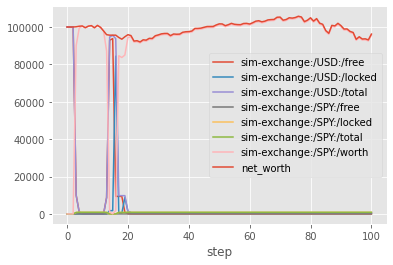

In [15]:
portfolio.performance.plot()

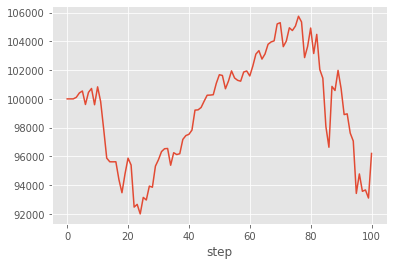

In [16]:
portfolio.performance.net_worth.plot()